In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u


In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'#'

start @ Tue May 26 14:53:12 2020#


In [3]:
p_radec=np.loadtxt('radio_source.txt')

In [4]:
output_file='./'

In [5]:
def cal_map_I(map_h, map_v):    
    assert(np.shape(map_h)==np.shape(map_v))
    map=(map_h+map_v)/2.   
    print 'min value h,v:',
    print np.ma.min(map_h),np.ma.min(map_v)
    assert(np.ma.min(map_h)>0)
    assert(np.ma.min(map_v)>0)
    diff_ratio=np.ma.exp(abs(np.ma.log(map_h)-np.ma.log(map_v))) #difference betwwen map h,v; 
                                                        #function to make sure maps are exchangable
    return map, diff_ratio


In [6]:
#fname,ant='1551037708','m000'#good,Left
fname,ant='1551055211','m000'#good,right
#fname,ant='1553966342','m042'#<800 good,left #PicA
#fname,ant='1554156377','m000'#good, right
#fname,ant='1556052116','m007'#<800 good, right
#fname,ant='1556138397','m031'#<800 good, right
#fname,ant='1562857793','m004'#good,right
print fname,ant

1551055211 m000


In [7]:
dh=pickle.load(open('/idia/projects/hi_im/raw_vis/katcali_output/level3_output/'+str(fname)+'_'+str(ant)+'h_level3_data'))
dv=pickle.load(open('/idia/projects/hi_im/raw_vis/katcali_output/level3_output/'+str(fname)+'_'+str(ant)+'v_level3_data'))

In [8]:
assert((dh['ra']==dv['ra']).all()==True)
assert((dh['dec']==dv['dec']).all()==True)
assert((dh['timestamps']==dv['timestamps']).all()==True)
assert((dh['Tgal_map']==dv['Tgal_map']).all()==True)
ra=dh['ra']
dec=dh['dec']
timestamps=dh['timestamps']
Tgal_map=dh['Tgal_map']

gain_map_h=dh['gain_map']
T_map_h=dh['T_map']
Tresi_map_h=dh['Tresi_map']
Tsm_map_h=dh['Tsm_map']
mask_nd_h=dh['mask_nd_s0'] #True is diode ON
Tel_map_h=dh['Tel_map']
Tsky_map_h=T_map_h-Tel_map_h-Tsm_map_h

gain_map_v=dv['gain_map']
T_map_v=dv['T_map']
Tresi_map_v=dv['Tresi_map']
Tsm_map_v=dv['Tsm_map']
mask_nd_v=dv['mask_nd_s0'] #True is diode ON
Tel_map_v=dv['Tel_map']
Tsky_map_v=T_map_v-Tel_map_v-Tsm_map_v


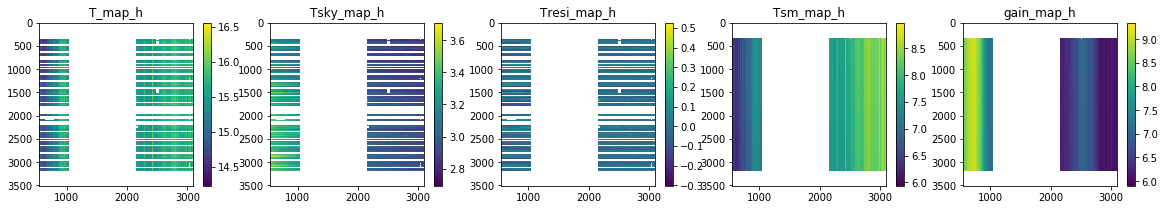

In [9]:
ch_e=3101
l=[T_map_h,Tsky_map_h,Tresi_map_h,Tsm_map_h,gain_map_h]
l_str=['T_map_h','Tsky_map_h','Tresi_map_h','Tsm_map_h','gain_map_h']
plt.figure(figsize=(20,3))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(1,len(l),l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(a,aspect='auto')
    plt.xlim(550,ch_e)
    plt.colorbar()
plt.show()

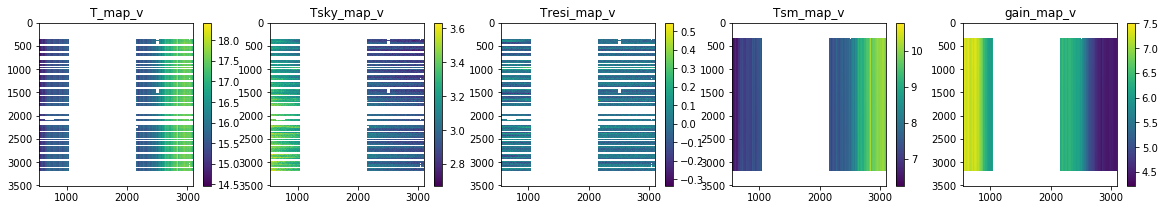

In [10]:
l=[T_map_v,Tsky_map_v,Tresi_map_v,Tsm_map_v,gain_map_v]
l_str=['T_map_v','Tsky_map_v','Tresi_map_v','Tsm_map_v','gain_map_v']
plt.figure(figsize=(20,3))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(1,len(l),l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(a,aspect='auto')
    plt.xlim(550,ch_e)
    plt.colorbar()
plt.show()

In [11]:
assert((T_map_h.mask==Tresi_map_h.mask).all()==True)
assert((T_map_v.mask==Tresi_map_v.mask).all()==True)
div=T_map_h/T_map_v
mask_clean=div.mask.copy()
mask_clean_backup=mask_clean.copy()

> The iteration 1 is in progress...
masks before and after filter are same: False
42 channels masked by 89 times
> The iteration 2 is in progress...
masks before and after filter are same: False
5 channels masked by 6 times
> The iteration 3 is in progress...
masks before and after filter are same: False
1 channels masked by 2 times
> The iteration 4 is in progress...
masks before and after filter are same: True
0 channels masked by 0 times
***filter done after iter time 4


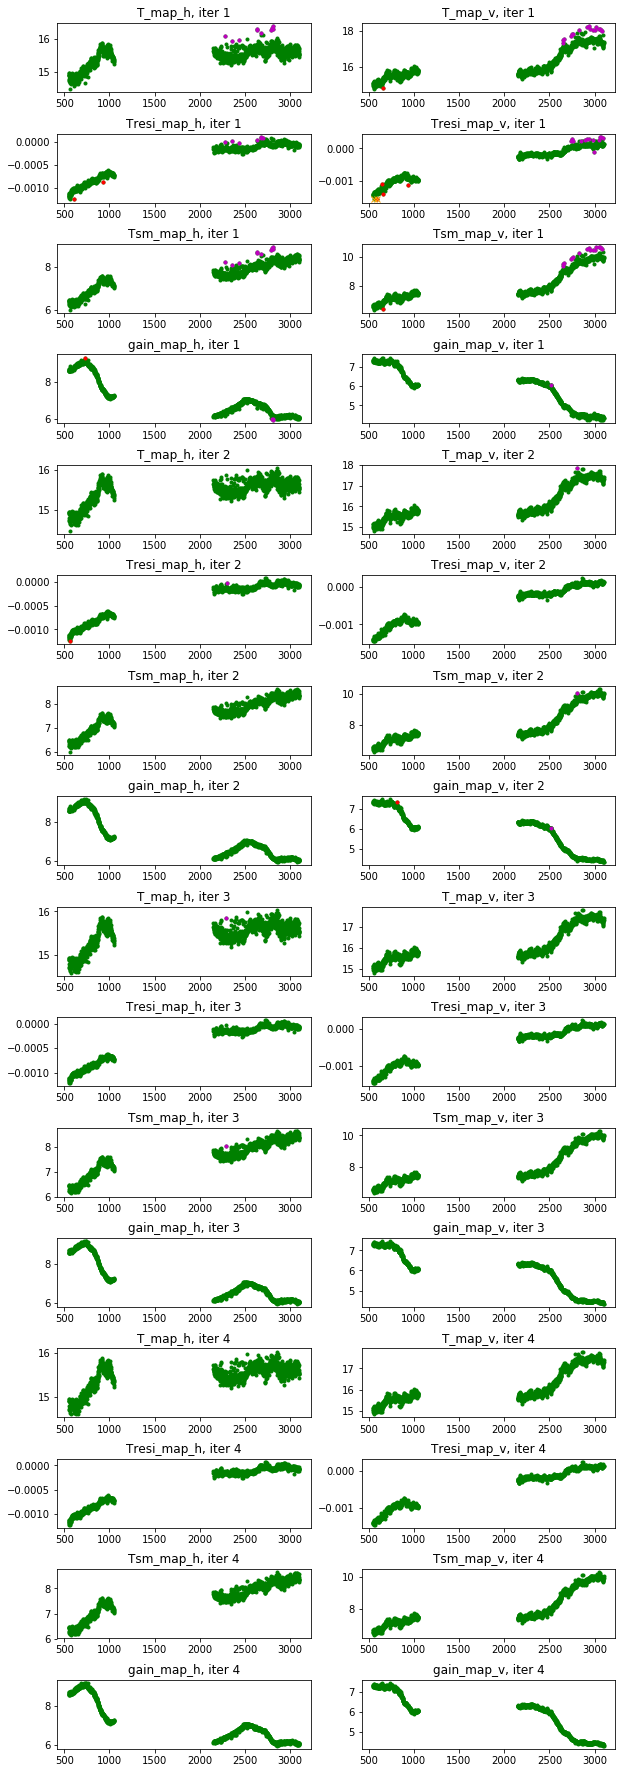

In [12]:
l=[T_map_h,T_map_v,Tresi_map_h,Tresi_map_v,Tsm_map_h,Tsm_map_v,gain_map_h,gain_map_v]
l_str=['T_map_h','T_map_v','Tresi_map_h','Tresi_map_v','Tsm_map_h','Tsm_map_v','gain_map_h','gain_map_v']

niter=6

plt.figure(figsize=(10,len(l)*niter))
plt.subplots_adjust (wspace=0.2, hspace=0.6) 
for i in range(niter):
    print '> The iteration '+str(i+1)+' is in progress...'
    mask_clean2=mask_clean.copy()
    
    del_point=[]
    
    for l_i in range(len(l)):
        a=l[l_i]
        plt.subplot(len(l)/2*niter,2,i*len(l)+l_i+1)
        a_ch=np.ma.mean(np.ma.array(a,mask=mask_clean),axis=0)
        plt.plot(a_ch,'g.')
        
        ax1=kf.curve_filter_ma_array(range(550,1051),a_ch[550:1051],sigma=4.)#550-1050 filter
        plt.plot(ax1,a_ch[ax1],'r.') #deleted data
        mask_clean2[:,ax1]=True ###apply to the mask
        del_point+=list(ax1)
        
        ax2=kf.curve_filter_ma_array(range(2150,3101),a_ch[2150:3101],sigma=4.)#2150-3100 filter
        plt.plot(ax2,a_ch[ax2],'m.') #deleted data
        mask_clean2[:,ax2]=True ###apply to the mask
        del_point+=list(ax2)
        
        ax3=kf.curve_filter_ma_array(range(550,3101),a_ch[550:3101],sigma=4.,k=1)
        plt.plot(ax3,a_ch[ax3],'x',c='orange') #deleted data
        mask_clean2[:,ax3]=True ###apply to the mask
        del_point+=list(ax3)
        
        plt.title(l_str[l_i]+', iter '+str(i+1))
    
    print 'masks before and after filter are same:',
    print (mask_clean==mask_clean2).all()
    mask_clean=mask_clean2.copy()
    
    print str(len(set(del_point))) + ' channels masked by '+str(len(del_point))+' times'
    if len(del_point)==0:
        print '***filter done after iter time '+str(i+1) 
        break
plt.savefig(output_file+fname+'_'+ant+'_ch_filter_iter'+str(i+1)+'.png')
plt.show()

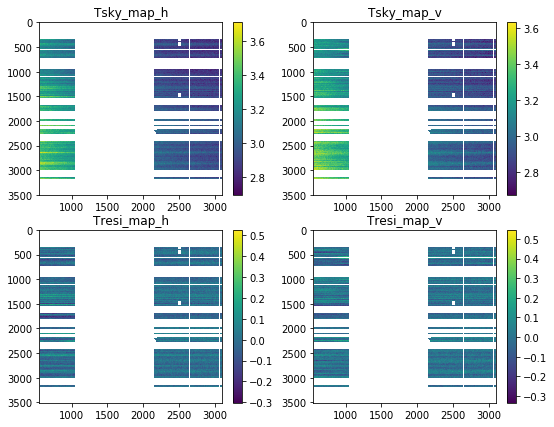

In [13]:
l=[Tsky_map_h, Tsky_map_v, Tresi_map_h, Tresi_map_v]
l_str=['Tsky_map_h', 'Tsky_map_v', 'Tresi_map_h', 'Tresi_map_v']
plt.figure(figsize=(9,7))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(len(l)/2,2,l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(np.ma.array(a,mask=mask_clean),aspect='auto')
    plt.xlim(550,ch_e)
    plt.colorbar()
plt.show()

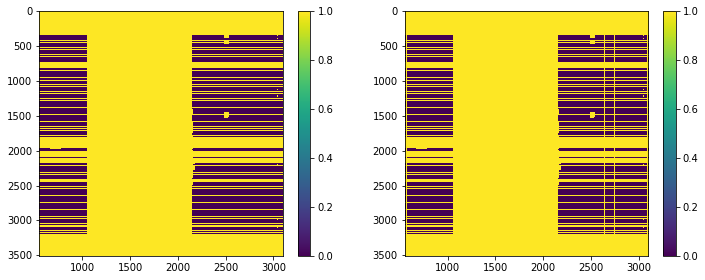

In [14]:
plt.figure(figsize=(12,4.5))
plt.subplot(121)
plt.imshow(mask_clean_backup,aspect='auto')
plt.xlim(550,ch_e)
plt.colorbar()
plt.subplot(122)
plt.imshow(mask_clean,aspect='auto')
plt.xlim(550,ch_e)
plt.colorbar()
plt.show()

In [15]:
Tsky_map_h=np.ma.array(Tsky_map_h,mask=mask_clean)
Tsky_map_v=np.ma.array(Tsky_map_v,mask=mask_clean)

Tresi_map_h=np.ma.array(Tresi_map_h,mask=mask_clean)
Tresi_map_v=np.ma.array(Tresi_map_v,mask=mask_clean)


In [16]:
Tsky_map,Tsky_ratio=cal_map_I(Tsky_map_h, Tsky_map_v)
Tresi_map=(Tresi_map_h+Tresi_map_v)/2.
assert((Tsky_map.mask==Tresi_map.mask).all()==True)

min value h,v: 2.69349339186 2.67137778577


/usr/lib/python2.7/dist-packages/numpy/ma/core.py:970: RuntimeWarning: overflow encountered in exp
  result = self.f(d, *args, **kwargs)


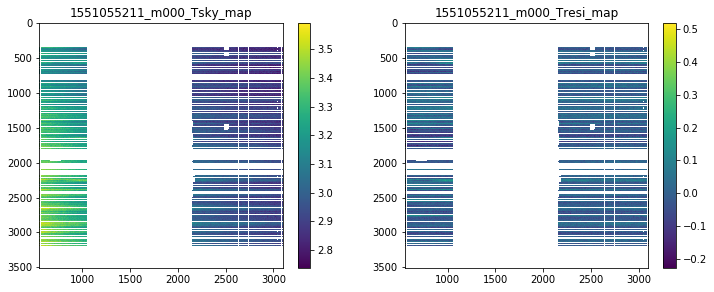

In [17]:
plt.figure(figsize=(12,4.5))
plt.subplot(121)
plt.imshow(Tsky_map,aspect='auto')
plt.xlim(550,ch_e)
plt.title(fname+'_'+ant+'_Tsky_map')
plt.colorbar()
plt.subplot(122)
plt.imshow(Tresi_map,aspect='auto')
plt.xlim(550,ch_e)
plt.title(fname+'_'+ant+'_Tresi_map')
plt.colorbar()
plt.savefig(output_file+fname+'_'+ant+'_Inten.png')
plt.show()



In [18]:
assert((Tsky_ratio.mask==mask_clean).all()==True)
print np.ma.max(Tsky_ratio)

1.12590410011


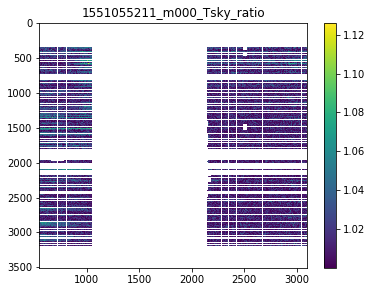

In [19]:
plt.figure(figsize=(6,4.5))
plt.imshow(Tsky_ratio,aspect='auto')
plt.xlim(550,ch_e)
plt.title(fname+'_'+ant+'_Tsky_ratio')
plt.colorbar()
plt.savefig(output_file+fname+'_'+ant+'_Tsky_ratio.png')
plt.show()

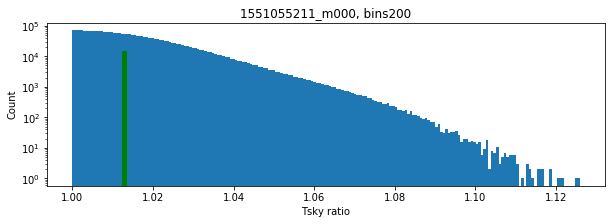

In [20]:
bins=200

plt.figure(figsize=(10,3))
max=np.sum(Tsky_ratio.mask==False)/bins
median=np.ma.median(Tsky_ratio)
plt.hist(Tsky_ratio[~Tsky_ratio.mask],bins=bins,log=True)
plt.plot([median,median],[0,max],'g-',lw=5)
plt.xlabel('Tsky ratio')
plt.ylabel('Count')
plt.title(fname+'_'+ant+', bins'+str(bins))
plt.savefig(output_file+fname+'_'+ant+'_Tsky_ratio_his.png')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


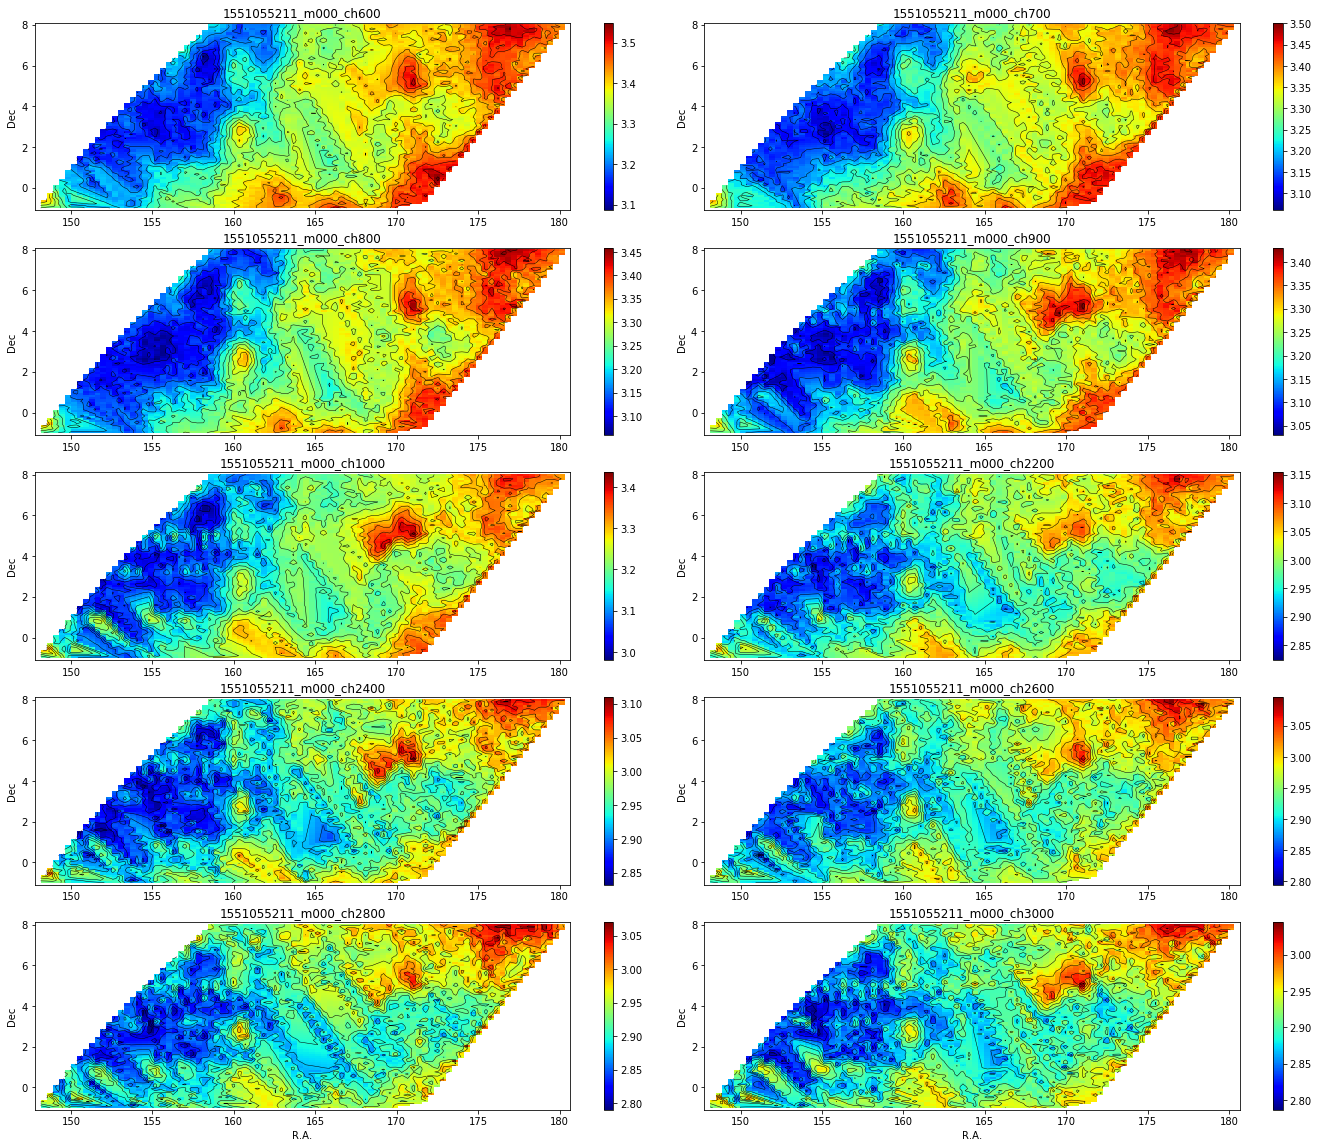

In [21]:
ch_plot_list=[600,700,800,900,1000,2200,2400,2600,2800,3000]
plt.figure(figsize=(24,20))
plt.subplots_adjust (wspace=0.0, hspace=0.2) 
for i in range(len(ch_plot_list)):
    ch_plot1=ch_plot_list[i]
    p_data=Tsky_map[:,ch_plot1]
    plt.subplot(5,2,i+1)
    try:
        kv.plot_data(ra,dec, p_data,gsize=90)
    except(Exception):
        kv.plot_data(ra,dec, np.zeros_like(ra),gsize=90)
    if i>len(ch_plot_list)-3:
        plt.xlabel('R.A.')
    plt.ylabel('Dec')
    plt.title(fname+'_'+ant+'_ch'+str(ch_plot1))
plt.savefig(output_file+fname+'_'+ant+'_Tsky_map.png')
plt.show()


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


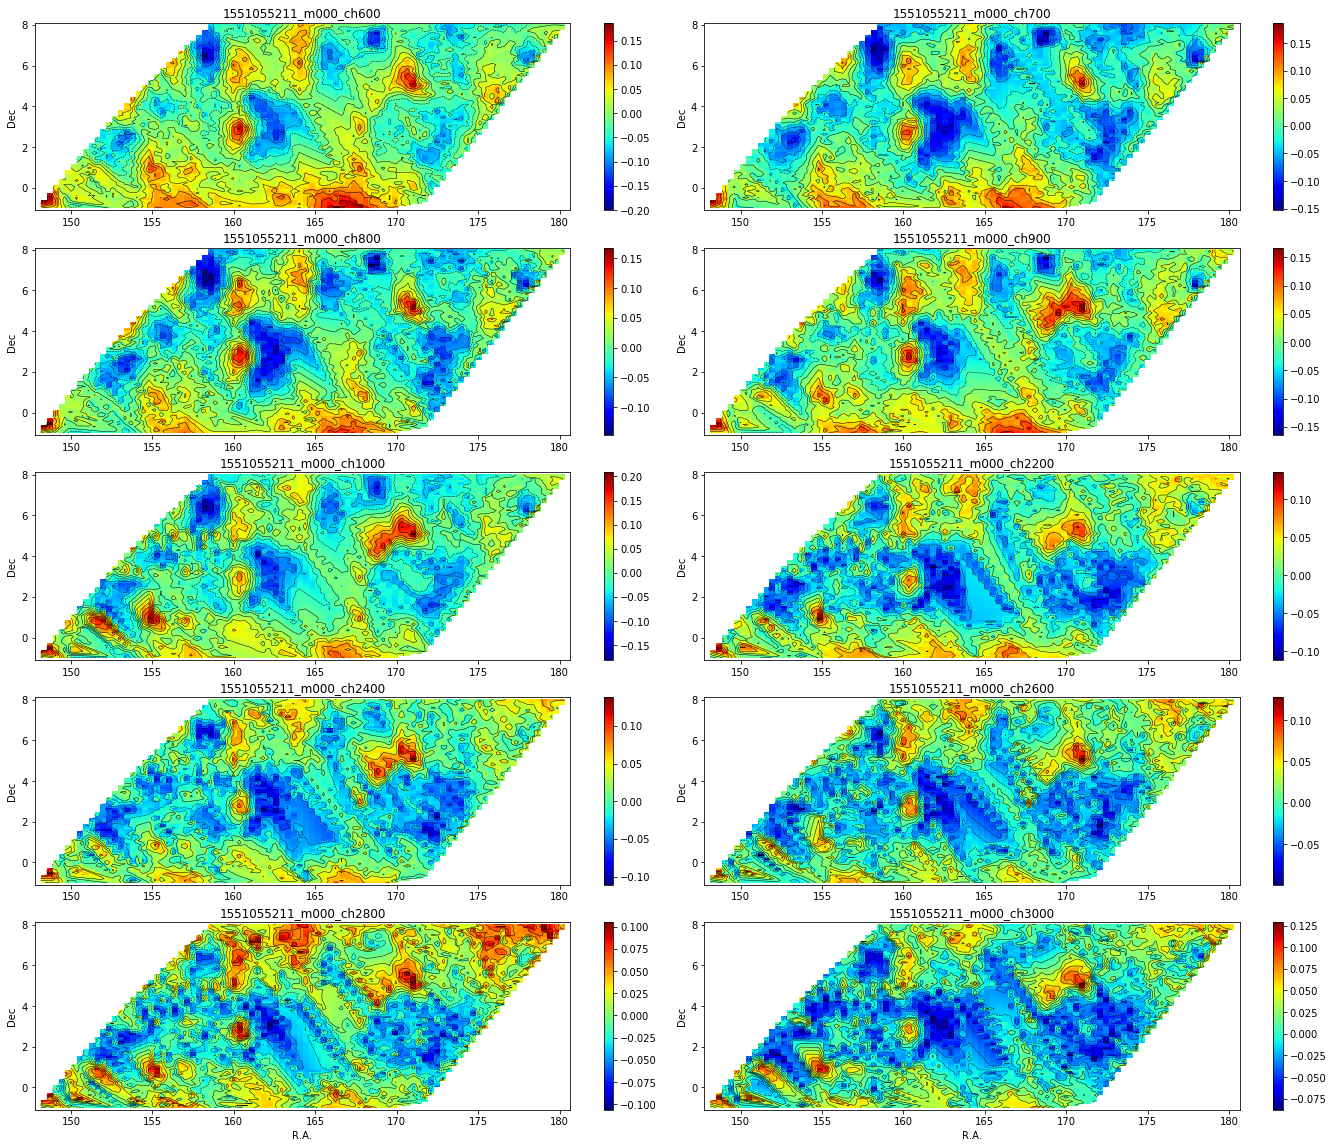

In [22]:
plt.figure(figsize=(24,20))
plt.subplots_adjust (wspace=0.0, hspace=0.2) 
for i in range(len(ch_plot_list)):
    ch_plot1=ch_plot_list[i]
    p_data=Tresi_map[:,ch_plot1]
    plt.subplot(5,2,i+1)
    try:
        kv.plot_data(ra,dec, p_data,gsize=90)
    except(Exception):
        kv.plot_data(ra,dec, np.zeros_like(ra),gsize=90)
    if i>len(ch_plot_list)-3:
        plt.xlabel('R.A.')
    plt.ylabel('Dec')
    plt.title(fname+'_'+ant+'_ch'+str(ch_plot1))
plt.savefig(output_file+fname+'_'+ant+'_Tresi_map.png')
plt.show()


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


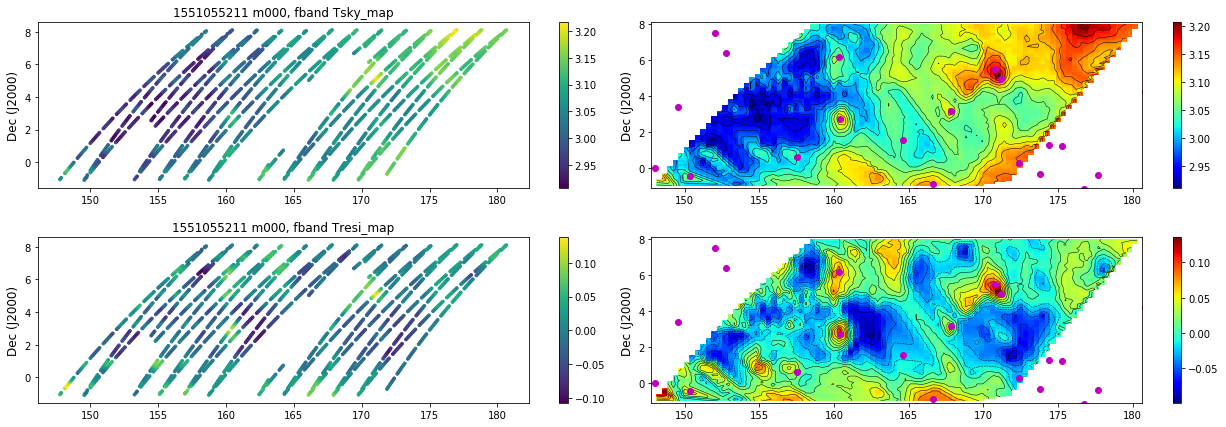

In [23]:
plot_gsize=90
plt.figure(figsize=(22,7))
plt.subplots_adjust(wspace=0,hspace=.3)

plt.subplot(221)
p_data=np.ma.mean(Tsky_map,axis=1)
plt.scatter(ra,dec, c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.ylabel('Dec (J2000)',fontsize=12)
plt.title(fname+' '+ant+', fband Tsky_map')
plt.colorbar()
plt.subplot(222)
kv.plot_data(ra,dec, p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.ylabel('Dec (J2000)',fontsize=12)

plt.subplot(223)
p_data=np.ma.mean(Tresi_map,axis=1)
plt.scatter(ra,dec, c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.ylabel('Dec (J2000)',fontsize=12)
plt.title(fname+' '+ant+', fband Tresi_map')
plt.colorbar()
plt.subplot(224)
kv.plot_data(ra,dec, p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.ylabel('Dec (J2000)',fontsize=12)
plt.savefig(output_file+fname+'_'+ant+'_fband_map.png')
plt.show()

In [24]:
assert((Tsky_map.mask==mask_clean).all()==True)
assert((Tresi_map.mask==mask_clean).all()==True)
assert((Tsky_ratio.mask==mask_clean).all()==True)

d={}
d['Tsky_map']=Tsky_map
d['Tresi_map']=Tresi_map
d['Tsky_ratio']=Tsky_ratio

d['timestamps']=timestamps
d['ra']=ra
d['dec']=dec
fs=open(output_file+str(fname)+'_'+str(ant)+'_level4_data','wb')
pickle.dump(d,fs,protocol=2)
fs.close()

d1={}

d1['Inten_mask']=mask_clean
fs=open(output_file+str(fname)+'_'+str(ant)+'_level4_mask','wb')
pickle.dump(d1,fs,protocol=2)
fs.close()

In [25]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Tue May 26 14:54:20 2020#


# reload data to check

In [26]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'

start @ Tue May 26 14:54:21 2020...


In [27]:
d2=pickle.load(open('/idia/projects/hi_im/raw_vis/katcali_output/level4_output/data/'+str(fname)+'_'+str(ant)+'_level4_data'))
assert((d2['Tsky_map'].mask==d2['Tresi_map'].mask).all()==True)

In [28]:
print d2.keys()

['Tresi_map', 'Tsky_map', 'ra', 'Tsky_ratio', 'timestamps', 'dec']


In [29]:
print d2['Tsky_ratio']

[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]


In [30]:
assert((d2['Tsky_map'].data==Tsky_map.data).all()==True)
assert((d2['Tsky_map'].mask==Tsky_map.mask).all()==True)

assert((d2['Tresi_map'].data==Tresi_map.data).all()==True)
assert((d2['Tresi_map'].mask==Tresi_map.mask).all()==True)


In [31]:
print d2['timestamps']

[  1.55105531e+09   1.55105531e+09   1.55105531e+09 ...,   1.55106232e+09
   1.55106232e+09   1.55106232e+09]


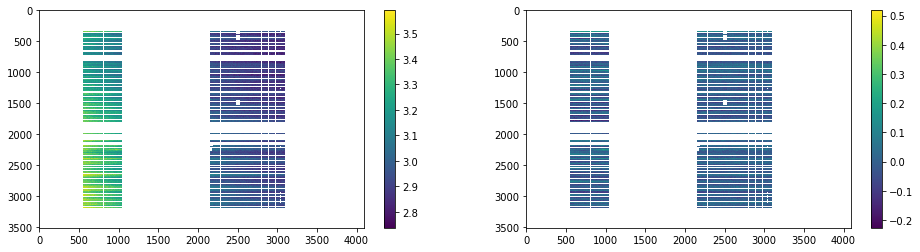

In [32]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(d2['Tsky_map'],aspect='auto')
plt.colorbar()
plt.subplot(122)
plt.imshow(d2['Tresi_map'],aspect='auto')
plt.colorbar()
plt.show()

In [33]:
d3=pickle.load(open('/idia/projects/hi_im/raw_vis/katcali_output/level4_output/mask/'+str(fname)+'_'+str(ant)+'_level4_mask'))

In [34]:
print d3.keys()

['Inten_mask']


In [35]:
assert((d3['Inten_mask']==mask_clean).all()==True)

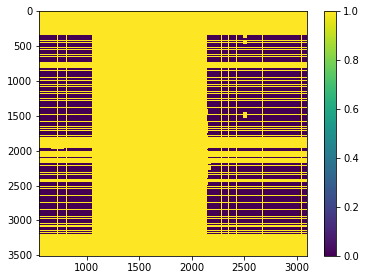

In [36]:
plt.figure(figsize=(6,4.5))
plt.imshow(d3['Inten_mask'],aspect='auto')
plt.xlim(550,ch_e)
plt.colorbar()
plt.show()

In [37]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Tue May 26 14:54:27 2020#
